In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = "google.colab" in sys.modules

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os
from pathlib import Path

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.


In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   웨이브 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + 웨이브 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + 잡음
    return series[..., np.newaxis].astype(np.float32)

In [8]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

series[:10]

array([[[ 4.59694803e-01],
        [ 3.14866781e-01],
        [ 1.24971226e-01],
        [-1.03913404e-01],
        [-3.38173866e-01],
        [-5.31671345e-01],
        [-6.54728830e-01],
        [-6.68099701e-01],
        [-6.06811523e-01],
        [-5.01683235e-01],
        [-2.79519230e-01],
        [-1.50706753e-01],
        [ 1.00181615e-02],
        [ 1.18607663e-01],
        [ 9.56641510e-02],
        [ 1.47929698e-01],
        [ 1.68506190e-01],
        [ 1.95247188e-01],
        [ 2.20940813e-01],
        [ 3.84486556e-01],
        [ 4.02110189e-01],
        [ 5.56697488e-01],
        [ 5.50006866e-01],
        [ 4.74372476e-01],
        [ 2.97333956e-01],
        [ 1.33065924e-01],
        [-1.29254699e-01],
        [-3.63672972e-01],
        [-4.95150536e-01],
        [-6.52797937e-01],
        [-6.66579187e-01],
        [-5.60457289e-01],
        [-5.03443539e-01],
        [-2.87751466e-01],
        [-1.26840621e-01],
        [-9.50529985e-03],
        [ 1.20243557e-01],
 

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

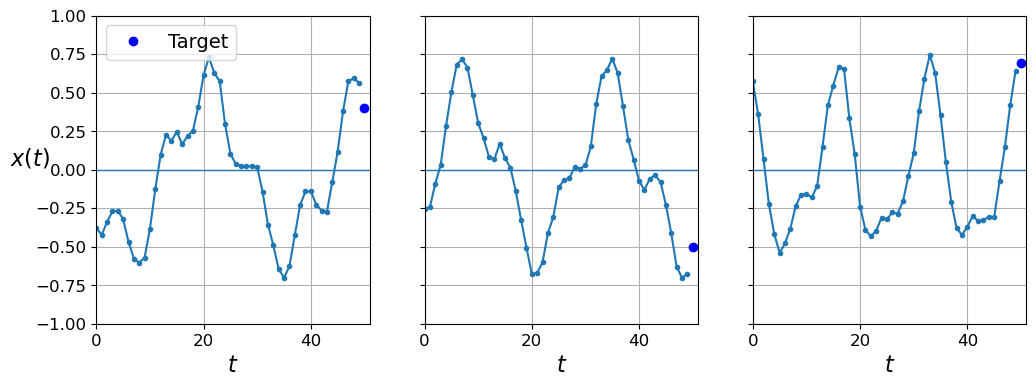

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid), validation_freq = 2)

model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 5s 13ms/step - loss: 0.0154
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0037
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0033
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0031
Epoch 8/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 9/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0030
Epoch 10/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 11/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0028
E

0.0025095674209296703